In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Q1. Do smokers have higher insurance charges than non-smokers?

- Null Hypothesis: "There is no significant difference in insurance charges between smokers and non-smokers"

- Alternate Hypothesis: "Insurance charges for smokers is significantly higher than those of non-smokers"

In [4]:
# Explore each group
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
# Filter data into smokers and non smokers
smoker_df = df.loc[df['smoker']=='yes'].copy()
non_smoker_df = df.loc[df['smoker']=='no'].copy()

In [6]:
# Define feature of interest
smoker_charge = smoker_df['charges']
non_smoker_charge = non_smoker_df['charges']

In [7]:
# Check each group for outliers - smokers
zscores = stats.zscore(smoker_charge)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [8]:
# no outliers to remove so we will check the non-smoking group
zscores = stats.zscore(non_smoker_charge)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [9]:
# Remove outliers from non-smoking group
non_smoker_charge = non_smoker_charge[(np.abs(stats.zscore(non_smoker_charge))
                                       <3)]

In [10]:
# Check for normality
result_smoker_charge = stats.normaltest(smoker_charge)
result_smoker_charge

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [11]:
result_non_smoker_charge = stats.normaltest(non_smoker_charge)
result_non_smoker_charge

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [12]:
## sample size is large enough to proceed without satisfying this test
# Check for equal variance
result = stats.levene(smoker_charge, non_smoker_charge)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

Our p value < alpha (0.05), so we reject the null hypothesis and accept that there is a significant difference between the insurance charges between smokers and non-smokers.

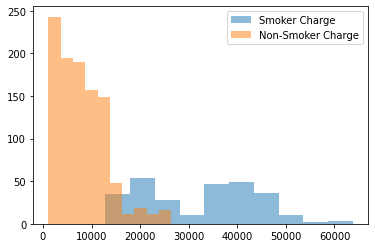

In [13]:
# Visualization
plt.hist(smoker_charge, alpha=0.5, label ='Smoker Charge')
plt.hist(non_smoker_charge, alpha=0.5, label='Non-Smoker Charge')
plt.legend()
plt.show()

# Q2. Are men more likely to smoke than women?

- Null Hypothesis: "There is no significant difference in the probability of a man smoking compared to a woman"

- Alternate Hypothesis: "There is a significant difference in the probability of a man smoking compared to a woman"

Text(0.5, 1.0, 'Number of Smokers by Sex')

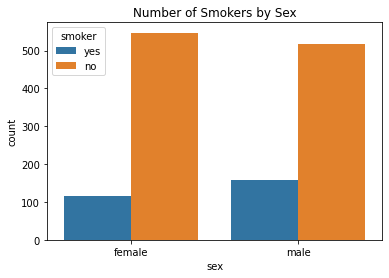

In [14]:
# Visualize smokers by sex
ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title('Number of Smokers by Sex')

In [15]:
# Calculate the contingency table
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [16]:
# Run the test and save the output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [17]:
print(p)

0.006548143503580696


Our p value < alpha (0.05), so we reject the null hypothesis and accept that there is a significant difference between the probability of a male being a smoker compared to a woman being a smoker.

# Q3. Do different regions have different charges, on average?

- Null Hypothesis: "There is no significant difference in charges based on region"

- Alternate Hypothesis: "There is a significant difference in charges based on region"

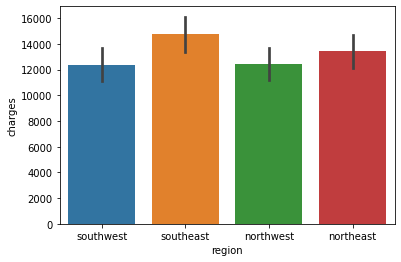

In [18]:
# Visualize the charges by region
sns.barplot(data=df, x='region', y='charges')

In [19]:
# Create a groups dictionary
groups = {}
# Loop through all unique categories
for i in df['region'].unique():
    data = df.loc[df['region']==i, 'charges'].copy()
    # Save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [20]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}

In [21]:
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [22]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [23]:
# Testing assumption of equal variance
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [24]:
# perform the hypothesis test
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

We now know that the result is significant, and we can run Tukeys Pairwise Multiple Comparison test in order to compare the significance in each region.

In [25]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values
values = df['charges']
labels = df['region']

In [26]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


from the summary above, we can see that there is only 1 significant result. We see that there is a significant difference in charges between the southeast and southwest. 